In [1]:
import numpy as np
from typing import List, Optional, Dict, Set, Callable, Any, Literal
from joblib import Memory, Parallel, delayed
import torch
from torch import Tensor
import matplotlib.pyplot as plt


from experiments.cross_validation import cv_UEA, print_cv_results
from experiments.eval_on_test import validate_UEA, print_test_results
from experiments.utils import join_dicts_from_pickle_paths, save_to_pickle, print_latex_results, load_dataset, print_shape, print_tensor
from experiments.experiment_code import run_all_kernels

/home/nikita/Code/kernel-timeseries-anomaly-detection/.conda/lib/python3.11/site-packages/pydantic/_migration.py:290: UserWarning: `pydantic.utils:deep_update` has been removed. We are importing from `pydantic.v1.utils:deep_update` instead.See the migration guide for more details: https://docs.pydantic.dev/latest/migration/
  warnings.warn(


# Cross Validation on Train

In [ ]:
cv_results = cv_UEA(
    dataset_names = [
        # 'Epilepsy',                    # N_corpus = 34
        'EthanolConcentration',        # N_corpus = 65
        # 'FingerMovements',             # N_corpus = 158
        # 'HandMovementDirection',       # N_corpus = 40
        # 'Heartbeat',                   # N_corpus = 102
        # 'LSST',                        # N_corpus = 176, N_train = 3000 ish
        # 'MotorImagery',                # N_corpus = 139
        # 'PEMS-SF',                     # N_corpus = 38
        # 'PhonemeSpectra',              # N_corpus = 85, N_train = 3000 ish
        # 'RacketSports',                # N_corpus = 38
        # 'SelfRegulationSCP1',          # N_corpus = 134
        # 'SelfRegulationSCP2',          # N_corpus = 100
        ],
    kernel_names = [
            "flat linear",
            "flat rbf",
            "flat poly",
            "integral rbf",
            "integral poly",
            "trunc sig linear",
            "trunc sig rbf",
            "pde sig rbf",
            "rand sig tanh",
            "gak",
            "reservoir",
        ],
        k_folds=3,
        n_repeats=1,
        verbose=False,
        omit_alpha=True, # for speed/debugging
)

# Validate on Test

In [ ]:
test_results = validate_UEA(cv_results, verbose=False, device="cuda")

In [ ]:
print(test_results)
print_test_results(test_results)

# Validate on Test and Save

In [ ]:
for dataset_name, cv_res in cv_results.items():
    test_results = validate_UEA({dataset_name : cv_res}, verbose=True, device="cuda")
    save_to_pickle(test_results, f"Data/results_{dataset_name}_part1.pkl")

# Read CV data from file and print results

In [2]:
# Load the cross validation results
cv_results = join_dicts_from_pickle_paths(
    [
    "Data/cv_Epilepsy.pkl",
    "Data/cv_EthanolConcentration.pkl",
    "Data/cv_FingerMovements.pkl",
    "Data/cv_HandMovementDirection.pkl",
    "Data/cv_Heartbeat.pkl",
    "Data/cv_LSST_part1.pkl",
    "Data/cv_LSST_part2.pkl",
    "Data/cv_LSST_part3.pkl",
    "Data/cv_MotorImagery.pkl",
    "Data/cv_PEMS-SF_part1.pkl",
    "Data/cv_PEMS-SF_part2.pkl",
    "Data/cv_PhonemeSpectra_part1.pkl",
    "Data/cv_PhonemeSpectra_part2.pkl",
    "Data/cv_PhonemeSpectra_part3.pkl", 
    "Data/cv_RacketSports.pkl",
    "Data/cv_SelfRegulationSCP1.pkl",
    "Data/cv_SelfRegulationSCP2.pkl",
    ])
print_cv_results(cv_results)

In [3]:
test_results = join_dicts_from_pickle_paths([
    "Data/results_Epilepsy.pkl",
    "Data/results_EthanolConcentration.pkl",
    "Data/results_FingerMovements.pkl",
    "Data/results_HandMovementDirection.pkl",
    "Data/results_Heartbeat.pkl",
    "Data/results_LSST_part1.pkl",
    "Data/results_LSST_part2.pkl",
    "Data/results_LSST_part3.pkl",
    "Data/results_MotorImagery.pkl",
    "Data/results_PEMS-SF_part1.pkl",
    "Data/results_PEMS-SF_part2.pkl",
    "Data/results_PhonemeSpectra_part1.pkl",
    "Data/results_PhonemeSpectra_part2.pkl",
    "Data/results_PhonemeSpectra_part3.pkl",
    "Data/results_RacketSports.pkl",
    "Data/results_SelfRegulationSCP1.pkl",
    "Data/results_SelfRegulationSCP2.pkl",
    ])
print_latex_results(test_results, round_digits=2)

# Print distribution of CV params

In [4]:
all_datasets = [
    "Epilepsy",
    "EthanolConcentration",
    "FingerMovements",
    "HandMovementDirection",
    "Heartbeat",
    "LSST",
    "MotorImagery",
    "PEMS-SF",
    "PhonemeSpectra",
    "RacketSports",
    "SelfRegulationSCP1",
    "SelfRegulationSCP2",
    ]

all_kernels = [
    "flat linear",
    "flat rbf",
    "flat poly",
    "integral rbf",
    "integral poly",
    "rand sig tanh",
    "trunc sig linear",
    "trunc sig rbf",
    "pde sig rbf",
    "gak",
    "reservoir",
    ]


def plot_cv_params_single_kernel(
        cv_results:Dict,
        param_name:str = "sigma", 
        kernel_name:str = "flat rbf", 
        datasets:Optional[List[str]] = None, 
        n_bins:int = 30,
    ):
    """
    For each dataset, plot the histogram of the best parameter
    values specified by 'param_name' for the kerenl "kernel_name".
    """
    if datasets is None:
        datasets = list(cv_results.keys())

    l = []
    for dataset_name, results in cv_results.items():
        if dataset_name in datasets:
            for anomaly_method in ["conf_results", "mahal_results"]:
                kernelwise_dict = results[anomaly_method]
                for ker, labelwise_dict in kernelwise_dict.items():
                    for label, param_dict in labelwise_dict.items():
                        if ker == kernel_name:
                            l.append(param_dict[param_name])
    l = np.array(l)
    l.sort()
    l = l.astype(str)

    plt.hist(l, n_bins)
    plt.xlabel(param_name)
    plt.ylabel("Frequency")
    plt.title(f"Kernel: {kernel_name}")
    plt.xticks(rotation='vertical')
    plt.show()



def plot_cv_params_all_kernels(
        cv_results:Dict,
        param_name:str = "sigma",
        kernels:Optional[List[str]] = None, 
        datasets:Optional[List[str]] = None,
        n_bins:int = 30,
    ):
    """
    For each dataset, plot the histogram of the best parameter
    values specified by 'param_name' for all the kernels.
    """
    if datasets is None:
        datasets = list(cv_results.keys())
    if kernels is None:
        kernels = list(cv_results[datasets[0]]["conf_results"].keys())

    l = []
    for dataset_name, results in cv_results.items():
        if dataset_name in datasets:
            for anomaly_method in ["conf_results", "mahal_results"]:
                kernelwise_dict = results[anomaly_method]
                for kernel_name, labelwise_dict in kernelwise_dict.items():
                    if kernel_name in kernels:
                        for label, param_dict in labelwise_dict.items():
                            if kernel_name == kernel_name:
                                if param_name in param_dict:
                                    l.append(param_dict[param_name])
    l = np.array(l)
    l.sort()
    l = l.astype(str)

    plt.hist(l, n_bins)
    plt.xlabel(param_name)
    plt.ylabel("Frequency")
    plt.title(f"All datasets: {param_name}")
    plt.xticks(rotation='vertical')
    plt.show()

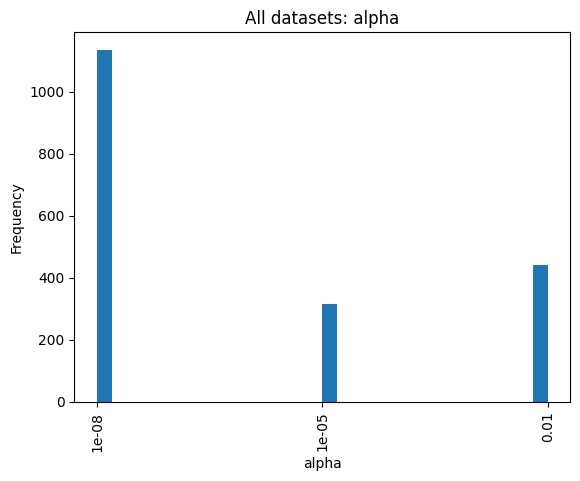

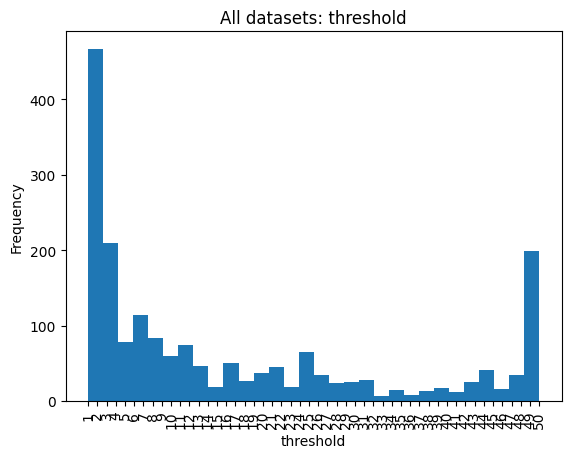

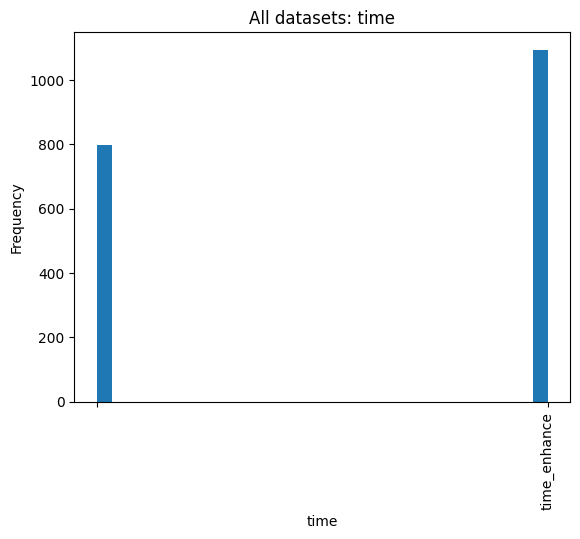

In [6]:
plot_cv_params_all_kernels(cv_results, "alpha")
plot_cv_params_all_kernels(cv_results, "threshold")
plot_cv_params_all_kernels(cv_results, "time")

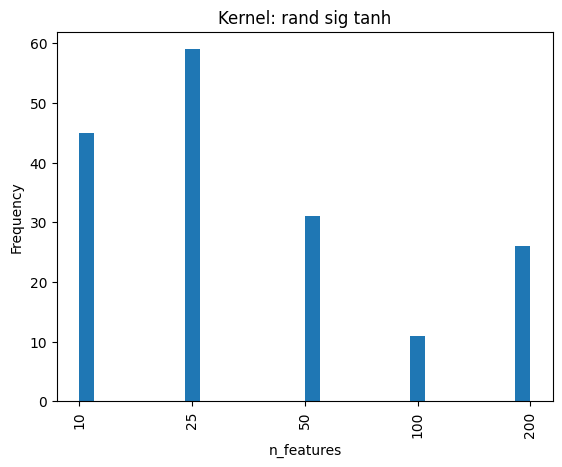

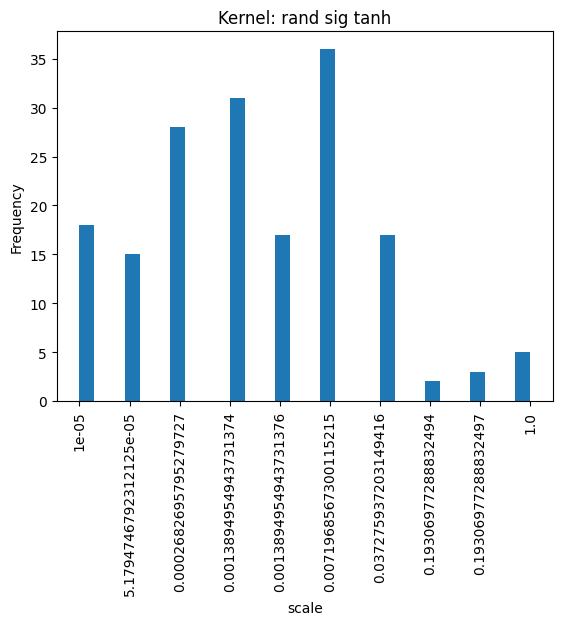

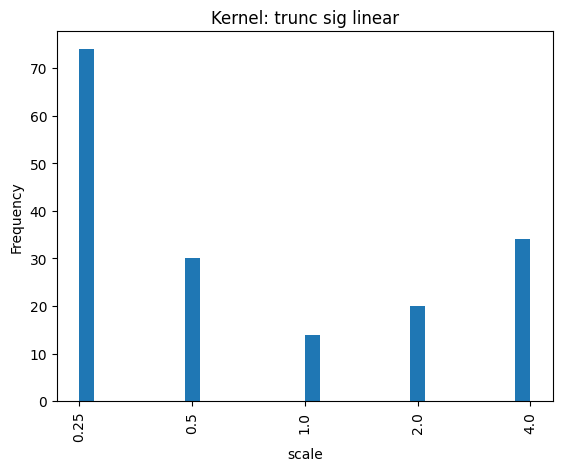

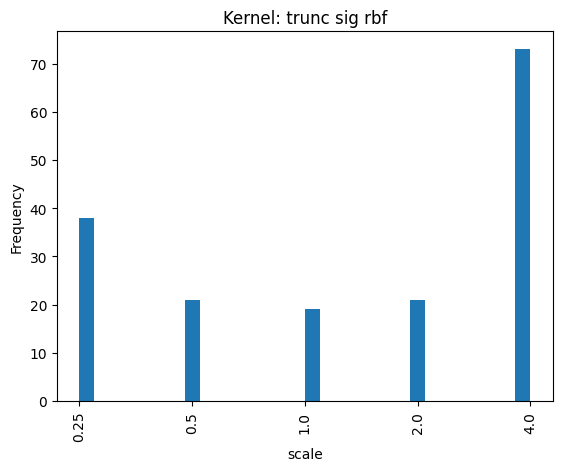

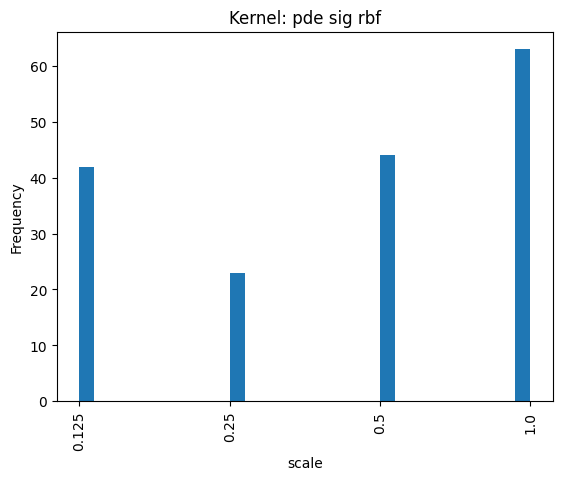

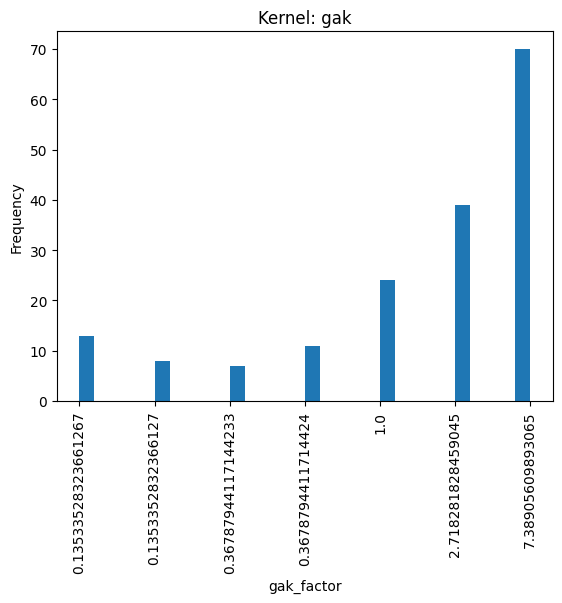

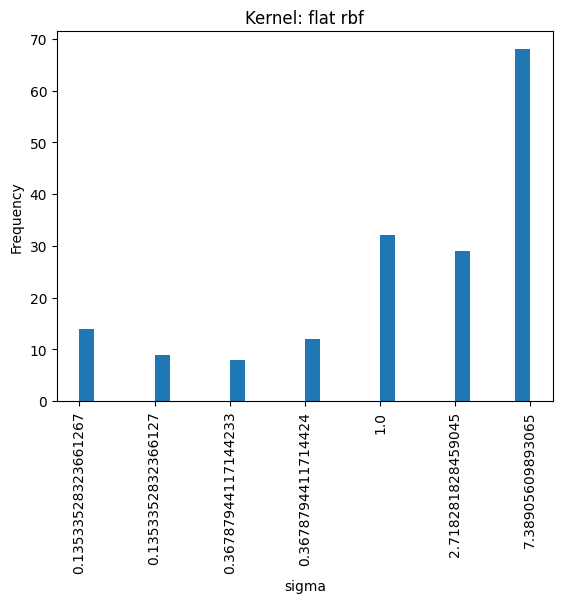

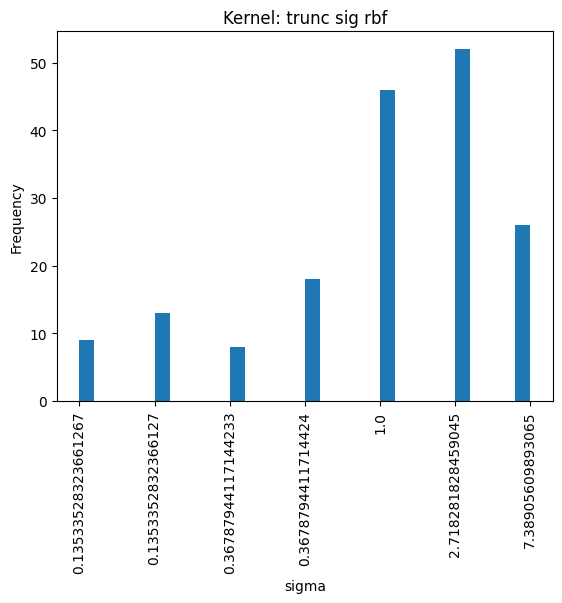

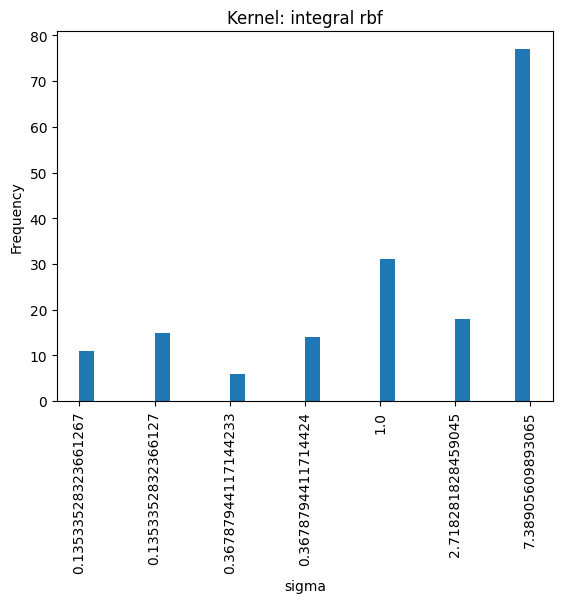

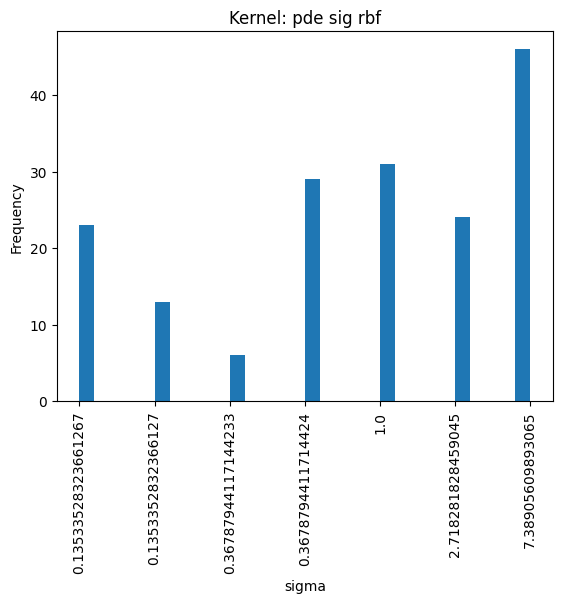

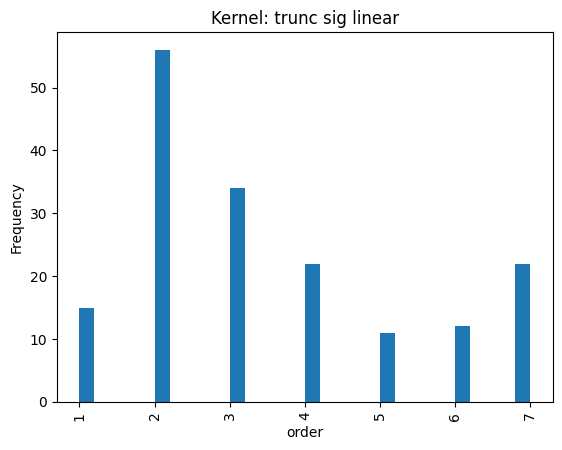

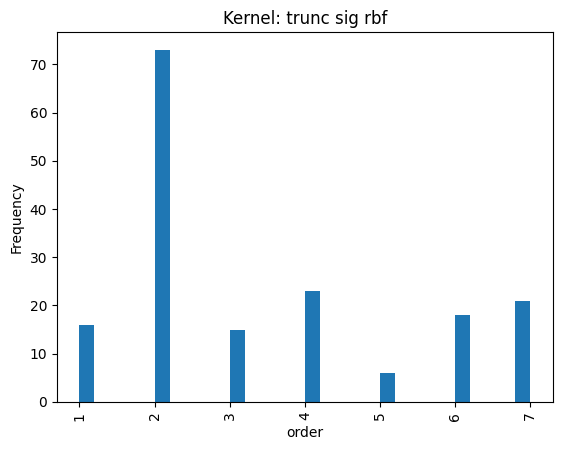

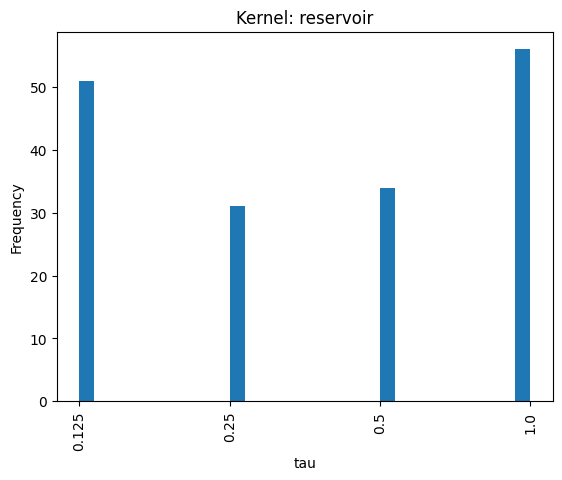

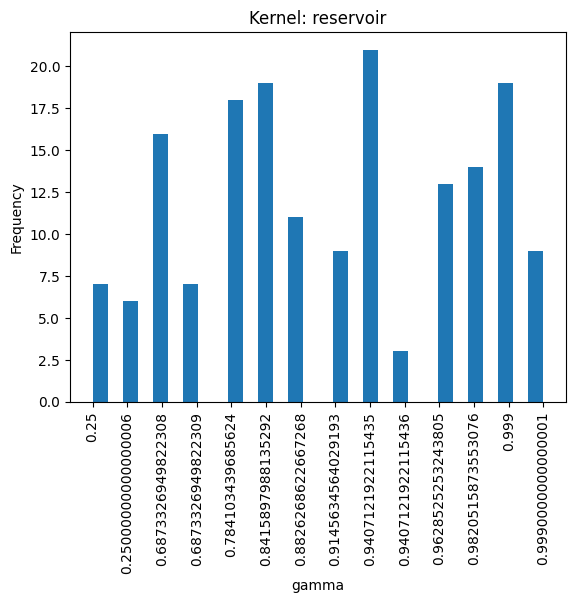

In [7]:
plot_cv_params_single_kernel(cv_results, "n_features", "rand sig tanh")
plot_cv_params_single_kernel(cv_results, "scale", "rand sig tanh")
plot_cv_params_single_kernel(cv_results, "scale", "trunc sig linear")
plot_cv_params_single_kernel(cv_results, "scale", "trunc sig rbf")
plot_cv_params_single_kernel(cv_results, "scale", "pde sig rbf")
plot_cv_params_single_kernel(cv_results, "gak_factor", "gak")
plot_cv_params_single_kernel(cv_results, "sigma", "flat rbf")
plot_cv_params_single_kernel(cv_results, "sigma", "trunc sig rbf")
plot_cv_params_single_kernel(cv_results, "sigma", "integral rbf")
plot_cv_params_single_kernel(cv_results, "sigma", "pde sig rbf")
plot_cv_params_single_kernel(cv_results, "order", "trunc sig linear")
plot_cv_params_single_kernel(cv_results, "order", "trunc sig rbf")
plot_cv_params_single_kernel(cv_results, "tau", "reservoir")
plot_cv_params_single_kernel(cv_results, "gamma", "reservoir")

# Make figure for paper

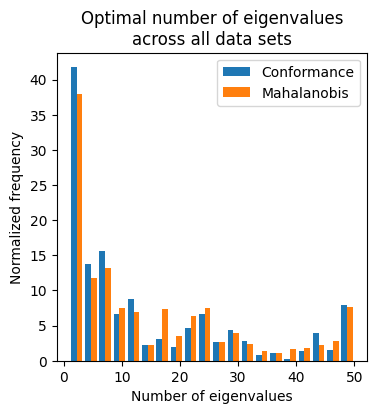

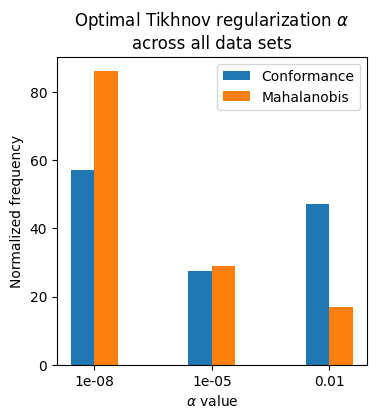

In [8]:
def plot_thresholds_and_alpha(
        cv_results:Dict,
        normalize_by_dataset:bool = True,
        size_x = 4,
        size_y = 4,
    ):
    l_thresh = [[], []]
    l_alpha = [[], []]
    l_weights = [[], []]
    for dataset_name, results in cv_results.items():
        for idx, anomaly_method in enumerate(["conf_results", "mahal_results"]):
            kernelwise_dict = results[anomaly_method]
            for kernel_name, labelwise_dict in kernelwise_dict.items():
                for label, param_dict in labelwise_dict.items():
                    l_thresh[idx].append(param_dict["threshold"])
                    l_alpha[idx].append(param_dict["alpha"])
                    l_weights[idx].append(1/len(labelwise_dict))
    l_thresh = np.array(l_thresh)
    l_alpha = np.array(l_alpha)
    thresh_weights = np.array(l_weights)
    if normalize_by_dataset:
        thresh_weights = np.array(l_weights)
        y_label = "Normalized frequency"
    else:
        thresh_weights = np.ones_like(l_thresh)
        y_label = "Frequency"

    # Threshold plot
    l_alpha = l_alpha.astype(str)
    fig = plt.figure(figsize=(size_x, size_y))
    ax = fig.add_subplot(111)
    #ax.hist(np.concatenate(l_thresh), bins=50, weights=np.concatenate(thresh_weights))
    ax.hist(l_thresh.T, bins=20, weights=thresh_weights.T, label=["Conformance", "Mahalanobis"])
    ax.set_title(f"Optimal number of eigenvalues\nacross all data sets")
    ax.set_xlabel("Number of eigenvalues")
    ax.set_ylabel(y_label)
    ax.legend(loc='upper right')
    plt.show()
    fig.savefig("Data/thresholds.pdf", format='pdf', dpi=600)


    # Alpha plot
    count = np.zeros((2, 3))
    count[:, 0] = ((l_alpha == "1e-08")*thresh_weights).sum(axis=1)
    count[:, 1] = ((l_alpha == "1e-05")*thresh_weights).sum(axis=1)
    count[:, 2] = ((l_alpha == "0.01")*thresh_weights).sum(axis=1)

    x_label = ("1e-08", "1e-05", "0.01")
    groups = {
        'Conformance': count[0],
        'Mahalanobis': count[1],
    }

    x = np.arange(len(x_label))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig = plt.figure(figsize=(size_x, size_y))
    ax = fig.add_subplot(111)
    for attribute, measurement in groups.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_xlabel("$\\alpha$ value")
    ax.set_title('Optimal Tikhnov regularization $\\alpha$\nacross all data sets')
    ax.set_xticks(x + width/2, x_label)
    ax.legend(loc='upper right')

    plt.show()
    fig.savefig("Data/alpha.pdf", format='pdf', dpi=600)


plot_thresholds_and_alpha(cv_results, normalize_by_dataset=True)

# Plot scatter plot

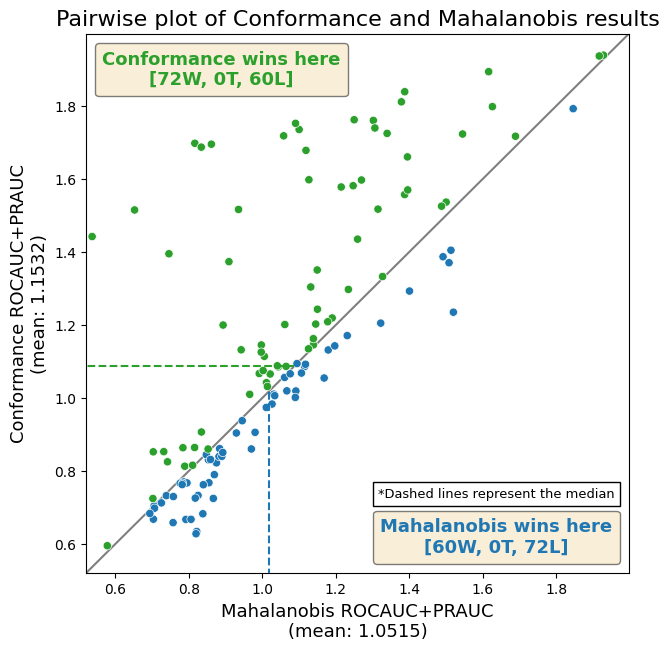

In [9]:
import numpy as np
from aeon.visualisation import plot_pairwise_scatter

all_datasets = [
    "Epilepsy",
    "EthanolConcentration",
    "FingerMovements",
    "HandMovementDirection",
    "Heartbeat",
    "LSST",
    "MotorImagery",
    "PEMS-SF",
    "PhonemeSpectra",
    "RacketSports",
    "SelfRegulationSCP1",
    "SelfRegulationSCP2",
    ]

all_kernels = [
    "flat linear",
    "flat rbf",
    "flat poly",
    "integral rbf",
    "integral poly",
    "gak",
    "reservoir",
    "trunc sig linear",
    "trunc sig rbf",
    "pde sig rbf",
    "rand sig tanh",
    ]

scores = np.zeros( (2, len(all_datasets), len(all_kernels), 2) ) # (conf_or_mah, dataset, kernel. roc_or_pr)
for i_data, dataset_name in enumerate(all_datasets):
    for j_ker, kernel_name in enumerate(all_kernels):
        for idx, anomaly_method in enumerate(["conf_results", "mahal_results"]):
            scores[idx, i_data, j_ker, 0] = test_results[dataset_name][anomaly_method][kernel_name][idx, 0]
            scores[idx, i_data, j_ker, 1] = test_results[dataset_name][anomaly_method][kernel_name][idx, 1]

conf_scores = scores[0]
mahal_scores = scores[1]

fig, _ = plot_pairwise_scatter(
    conf_scores.sum(axis=-1).reshape(-1),
    mahal_scores.sum(axis=-1).reshape(-1),
    "Conformance",
    "Mahalanobis",
    metric="ROCAUC+PRAUC",
    lower_better = False,
    statistic_tests=False,
    title = "Pairwise plot of Conformance and Mahalanobis results",
    figsize = (7,7),
    color_palette=None,
)
fig.savefig("Data/scatter.pdf", format='pdf', dpi=400)
plt.show()
